In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
plt.style.use('fivethirtyeight')

In [2]:
import keras
print('tensorflow:',tf.__version__)
print('keras:',keras.__version__)

tensorflow: 2.8.4
keras: 2.8.0


In [3]:
security = 'DLR'
df = yf.download(security)
his_period = 60

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-06,132.309998,132.320007,127.739998,129.490005,129.490005,1959300
2023-11-07,129.500000,129.509995,127.919998,127.980003,127.980003,1708800
2023-11-08,127.959999,128.899994,127.269997,128.449997,128.449997,965000
2023-11-09,128.759995,129.500000,127.139999,127.610001,127.610001,944800
2023-11-10,128.259995,129.169998,126.220001,128.750000,128.750000,1571000
2023-11-13,127.879997,128.839996,126.870003,127.650002,127.650002,869300
2023-11-14,132.169998,135.470001,131.309998,134.300003,134.300003,2123700
2023-11-15,134.110001,136.110001,133.800003,134.600006,134.600006,1726500
2023-11-16,135.250000,136.550003,134.350006,135.149994,135.149994,1458800


In [5]:
plt.figure(figsize=(16,8), dpi=800)
plt.title('{} Close Price History'.format(security))
plt.plot(df['Close'], linewidth=2.5)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
# 使用AutoDateLocator自动确定日期的显示间隔
date_locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(date_locator)
# 设置日期的显示格式为"%Y-%m"，即年份-月份
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.savefig('{}.png'.format(security))


plt.show()

In [6]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

3838

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.74361624],
       [0.74695213],
       [0.74319162]])

In [8]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(his_period, len(train_data)):
    x_train.append(train_data[i-his_period:i, 0])
    y_train.append(train_data[i, 0])


In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3778, 60, 1)

In [11]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.2))
# model.add(LSTM(100, return_sequences=True))
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# 训练 & 保存模型。
model.fit(x_train, y_train, batch_size=300000, epochs=1000)
model.save_weights('{}_lstm_model.h5'.format(security))

Epoch 1/1000


1/1 [==============================] - 7s 7s/step - loss: 0.1245
Epoch 2/1000
1/1 [==============================] - 0s 146ms/step - loss: 0.0445
Epoch 3/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.0040
Epoch 4/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.0225
Epoch 5/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.0203
Epoch 6/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.0059
Epoch 7/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.0018
Epoch 8/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.0042
Epoch 9/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.0077
Epoch 10/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.0094
Epoch 11/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.0087
Epoch 12/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.0067
Epoch 13/1000
1/1 [======================

In [14]:
#直接载入权重模型。
# model.load_weights("VNQ_lstm_model.h5")

In [15]:
test_data = scaled_data[training_data_len - his_period:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(his_period, len(test_data)):
    x_test.append(test_data[i-his_period:i, 0])

In [16]:
x_test = np.array(x_test)

In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(959, 60, 1)

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
rmse=np.sqrt(((predictions - y_test) ** 2).mean())
rmse

4.824299710170685

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Steven Chen\AppData\Local\Temp\ipykernel_28264\2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


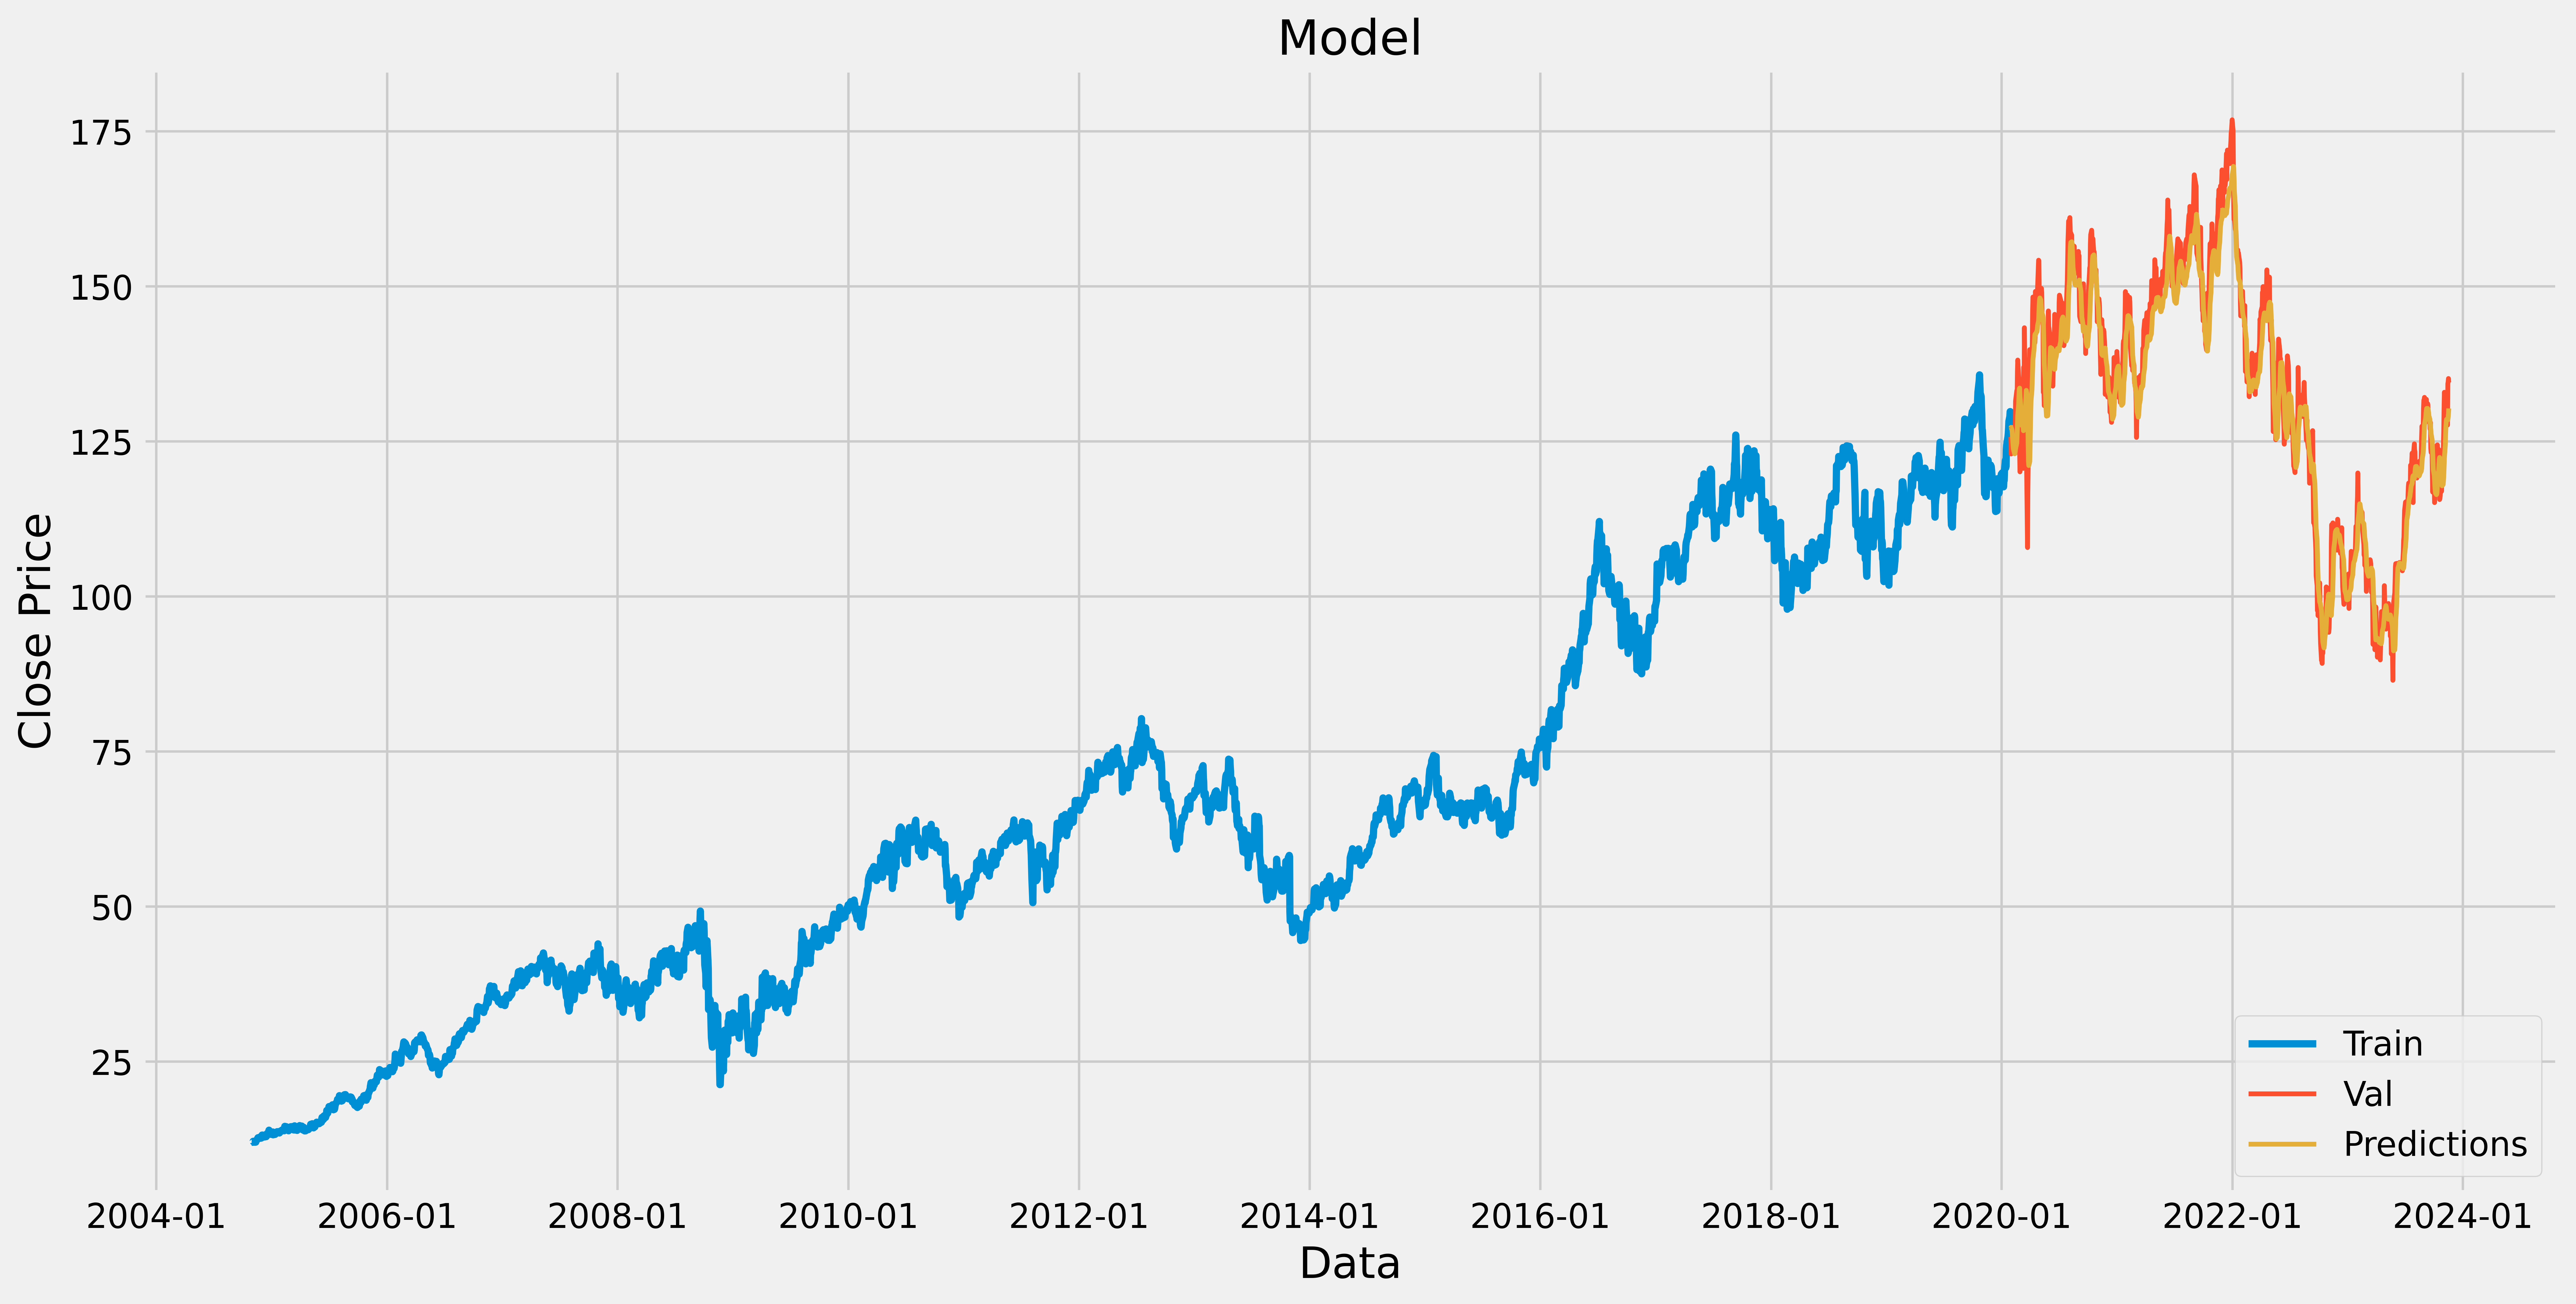

In [21]:
plt.figure(figsize=(16, 8), dpi=600)
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'], linewidth=3)
plt.plot(valid[['Close', 'Predictions']], linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# 使用AutoDateLocator自动确定日期的显示间隔
date_locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(date_locator)
# 设置日期的显示格式为"%Y-%m"，即年份-月份
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.savefig("{}_LSTM_predict.jpg".format(security))
plt.show()

In [22]:
last_days = df.filter(['Close'])[-his_period:].values
last_days_scaled = scaler.transform(last_days)
X_test = []
X_test.append(last_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[131.16074]]
